In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 
from torch.autograd import Variable
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Clean Data

CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed.

In [2]:
# breath_df = get_breath_df('data_sdx_', 1400, 100)

In [3]:
# breath_df.to_pickle('breath_pickle_cnn')

In [4]:
breath_df = pd.read_pickle('breath_pickle_sound')
breath_df.head(2)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"
1,"[0.4727, 0.4687, 0.4646, 0.4605, 0.4563, 0.452...",30.61,31.40,"[0.0006, 0.0009, 0.0013, 0.0017, 0.0022, 0.002...","[2386, 2387, 2388, 2389, 2390, 2391, 2392, 239...","(2386, 5525)"


In [5]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [6]:
median_bh = under2['Data_breath_holds'].median()
under2['class'] = np.where(under2['Data_breath_holds'] < median_bh, 0, 1) # create encoded column: short (0), long (1)

In [7]:
df = under2

In [8]:
q25 = under2['Data_breath_holds'].quantile(.25)
q75 = under2['Data_breath_holds'].quantile(.75)

In [9]:
under2 = under2[(under2['Data_breath_holds'] < q25) | (under2['Data_breath_holds'] > q75)] # only consider breathholds in upper and lower quartiles

In [10]:
under2['class'] = np.where(under2['Data_breath_holds'] < q25, 0, 1) # create encoded column: short (0), long (1)

In [11]:
under2.head()

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end,class
9,"[1.0032, 1.0018, 1.0002, 0.9986, 0.9969, 0.995...",25.44,25.05,"[0.0008, 0.0018, 0.0021, 0.0024, 0.0028, 0.003...","[2205, 2206, 2207, 2208, 2209, 2210, 2211, 221...","(2205, 4709)",0
13,"[0.6626, 0.6662, 0.6698, 0.6733, 0.6768, 0.680...",24.41,24.44,"[0.0004, 0.0011, 0.002, 0.0032, 0.0045, 0.006,...","[2095, 2096, 2097, 2098, 2099, 2100, 2101, 210...","(2095, 4538)",0
14,"[0.7085, 0.7118, 0.7151, 0.7184, 0.7217, 0.724...",26.02,25.66,"[0.0002, 0.0006, 0.001, 0.0015, 0.002, 0.0026,...","[2069, 2070, 2071, 2072, 2073, 2074, 2075, 207...","(2069, 4634)",0
15,"[0.7846, 0.7867, 0.7888, 0.7909, 0.793, 0.795,...",26.43,25.11,"[0.0002, 0.0007, 0.0015, 0.0026, 0.004, 0.0057...","[2070, 2071, 2072, 2073, 2074, 2075, 2076, 207...","(2070, 4580)",0
16,"[0.6163, 0.6212, 0.626, 0.6307, 0.6354, 0.6401...",25.27,25.06,"[0.0016, 0.0021, 0.0028, 0.0037, 0.0047, 0.005...","[2171, 2172, 2173, 2174, 2175, 2176, 2177, 217...","(2171, 4676)",0


# Split and Normalize Data

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.60)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [14]:
# Change type of each row from np.array to list to put into scaler
x_train = np.array([list(row) for row in x_train])
x_val = np.array([list(row) for row in x_val])
x_test = np.array([list(row) for row in x_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [15]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Playing and debugging CNN layers

In [16]:
D = 300
N = 40

In [17]:
x = x_train[:2]
x.shape

(2, 1500)

In [18]:
x = torch.tensor(x,dtype=torch.float32)
x.shape

torch.Size([2, 1500])

In [19]:
x1 = torch.unsqueeze(x, dim=1)  # needs to convert x to (batch, embedding_dim, sentence_len)
x1.shape


torch.Size([2, 1, 1500])

In [20]:
conv_3=nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)

In [21]:
x3 = conv_3(x1)
x3.size()

torch.Size([2, 100, 1498])

In [22]:
conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)

In [23]:
x4 = conv_4(x1)
x5 = conv_5(x1)
print(x4.size(), x5.size())

torch.Size([2, 100, 1497]) torch.Size([2, 100, 1496])


In [24]:
# 100 3-gram detectors
x3 = nn.ReLU()(x3)
x3 = nn.MaxPool1d(kernel_size = 1498)(x3)
x3.size()

torch.Size([2, 100, 1])

In [25]:
# 100 4-gram detectors
x4 = nn.ReLU()(x4)
x4 = nn.MaxPool1d(kernel_size = 1497)(x4)
x4.size()

torch.Size([2, 100, 1])

In [26]:
# 100 5-gram detectors
x5 = nn.ReLU()(x5)
x5 = nn.MaxPool1d(kernel_size = 1496)(x5)
x5.size()

torch.Size([2, 100, 1])

In [27]:
# concatenate x3, x4, x5
out = torch.cat([x3, x4, x5], 2)
out.size()

torch.Size([2, 100, 3])

In [28]:
out = out.view(out.size(0), -1)
out.size()

torch.Size([2, 300])

## CNN Model

In [29]:
class myCNN(nn.Module):
    
    def __init__(self, D):
        super(myCNN, self).__init__()
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=1, out_channels=100, kernel_size=5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        
        x3 = nn.MaxPool1d(kernel_size = 1498)(x3)
        x4 = nn.MaxPool1d(kernel_size = 1497)(x4)
        x5 = nn.MaxPool1d(kernel_size = 1496)(x5)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        
        return self.fc(out) 

In [30]:
# Testing the model
model = myCNN(1)

In [31]:
x = x_train[:10]
x = torch.tensor(x,dtype=torch.float32)
model(x)

tensor([[-0.2653],
        [-0.6760],
        [ 0.0572],
        [-0.7622],
        [-0.4694],
        [-0.8595],
        [ 0.1210],
        [-0.0306],
        [-0.5402],
        [-0.1550]], grad_fn=<AddmmBackward0>)

## Training

In [32]:
#def train(model, x_train, y_train):
model = myCNN(1)

In [33]:
# this filters parameters with p.requires_grad=True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)

In [34]:
def train_epocs(model, epochs=10, lr=0.01):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    model.train()
    losses = []
    for i in range(epochs):
        x = Variable(torch.tensor(x_train,dtype=torch.float32))
        y = Variable(torch.tensor(y_train,dtype=torch.float32)).unsqueeze(1)
        y_hat = model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
        losses.append(loss.item())
    test_metrics(model)
    return losses

In [35]:
def test_metrics(m):
    model.eval()
    x = Variable(torch.tensor(x_test,dtype=torch.float32))
    y = Variable(torch.Tensor(y_test)).unsqueeze(1)
    y_hat = m(x)
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    y_pred = y_hat > 0
    correct = (y_pred.float() == y).float().sum()
    accuracy = correct/y_pred.shape[0]
    print("test loss %.3f and accuracy %.3f" % (loss.item(), accuracy))

In [36]:
losses = train_epocs(model, epochs=20, lr=0.01)

0.7280896902084351
0.8864974975585938
0.7800260186195374
0.8266193866729736
0.735830545425415
0.7355087995529175
0.7883255481719971
0.7378336787223816
0.7143096327781677
0.7239702343940735
0.7423444986343384
0.7316452860832214
0.7041357755661011
0.7088527083396912
0.7205995917320251
0.7331069111824036
0.7153362035751343
0.7083597183227539
0.7080092430114746
0.7081800699234009
test loss 0.708 and accuracy 0.494


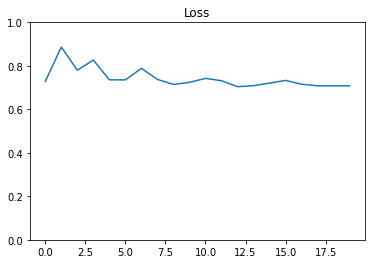

In [49]:
plt.plot(losses)
plt.ylim(0,1)
plt.title('Loss')
plt.show()